# $|10\rangle$ and $|01\rangle$ states tests
This Jupyter Notebook is used to carry out the dynamical decoupling tests with the $|10\rangle$ and $|01\rangle$ (two-qubit) states and the three simple universal sequences XYXY, XZXZ and YZYZ (and free evolution IIII). This notebook is adapted from the ones corresponding to the $|\psi_{ab}\rangle$ and Bell states.

### Load the libraries

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, schedule, transpiler
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.tools import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager

import numpy as np
import matplotlib.pyplot as plt

# For data fitting
from lmfit import Model

### Get the provider with your account id and set the backend (ibmq_lima)

In [2]:
provider = IBMQ.enable_account('your-ibmq-id-here')

In [3]:
backend = provider.get_backend('ibmq_lima')

### Get information about the duration of some of the instructions of the backend

In [4]:
# Get duration of instructions
dt_in_s = backend.configuration().dt
Reset_duration = transpiler.InstructionDurations.from_backend(backend).get("reset",4)
I_duration     = transpiler.InstructionDurations.from_backend(backend).get("id",4)
Z_duration     = transpiler.InstructionDurations.from_backend(backend).get("rz",4)
SX_duration    = transpiler.InstructionDurations.from_backend(backend).get("sx",4)
X_duration     = transpiler.InstructionDurations.from_backend(backend).get("x",4)
Y_duration     = 3*Z_duration + 2*SX_duration
H_duration     = 2*Z_duration + SX_duration
Measurement_duration = transpiler.InstructionDurations.from_backend(backend).get("measure",4)

### Define the functions for obtaining the $b$ and $\theta$ parameters from $a$

$$a\in [0,\,1]\mbox{ (positive $a$ case)}\quad \mbox{or}\quad a\in[-1,\,0]\mbox{ (negative $a$ case)}$$

$$a^2+b^2=1 \longrightarrow b = \sqrt{1-a^2}$$

$$a = \cos\left(\frac{\theta}{2}\right) \longrightarrow \theta = 2 \arccos(a)$$

In [9]:
def b(a):
    return np.sqrt(1-a**2)

def theta(a):
    return 2*np.arccos(a)

### Define the function that generates the circuits

In [6]:
def get_transpiled_circuit(num_blocks, backend, 
                           X_duration, Y_duration, dt_in_s,
                           a_value=0, dynamicalDecoupling=True, sequence="XYXY"): 

    """
    a_value: 0 or 1
    dynamicalDecoupling: True, False
    sequence: "XYXY", "XZXZ", "YZYZ"
    qubits used -> qubit 3 and qubit 4
    
    The main circuit is divided into subcircuits: data preparation, dynamical decoupling, inverse of data preparation, measurement.
    """
    
    # Duration of the 4-gate blocks of the sequences (the duration of a Z gate is 0)
    tau_block = {"XYXY":2*(X_duration+Y_duration),
                 "XZXZ":2*X_duration,
                 "YZYZ":2*Y_duration}
    
    # Data preparation subcircuit
    dataCircuit = QuantumCircuit(5, 2)
    dataCircuit.x(4)
    dataCircuit.ry(theta(a_value), 3)
    dataCircuit.cnot(3,4)
    dataCircuit = transpile(dataCircuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    # Dynamical decoupling sequence subcircuit
    ddCircuit = QuantumCircuit(5, 2)
    # Apply dynamical decoupling or wait
    if dynamicalDecoupling == True:   
        for i in range(num_blocks): # Put the sequence 4-gate blocks on both qubits
            if sequence == "XYXY":
                ddCircuit.x([3,4])
                ddCircuit.y([3,4])
                ddCircuit.x([3,4])
                ddCircuit.y([3,4])
            elif sequence == "XZXZ":
                ddCircuit.x([3,4])
                ddCircuit.z([3,4])
                ddCircuit.x([3,4])
                ddCircuit.z([3,4])
            elif sequence == "YZYZ":
                ddCircuit.y([3,4])
                ddCircuit.z([3,4])
                ddCircuit.y([3,4])
                ddCircuit.z([3,4])
    elif dynamicalDecoupling == False:
        # Set the number of identity gates in a free evolution block 
        # so that it has the same duration as the block from the 
        # corresponding dynamical decoupling sequence
        num_ids = {"XYXY":6, "XZXZ":2, "YZYZ":4}
        # Build the free evolution part.
        for i in range(num_blocks): # Put the identity gate blocks of the free evolution
            for j in range(num_ids[sequence]):
                ddCircuit.id([3,4]) # How a single block is built
    # Transpile the dynamical decoupling subcircuit
    ddCircuit = transpile(ddCircuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    tau_wait  = num_blocks*tau_block[sequence] # Duration of the dynamical decoupling sequence
    wait_duration = tau_wait*dt_in_s*1e6 # Convert the duration from system units (dt) to microseconds
    
    # Measuerement subcircuit
    measCircuit = QuantumCircuit(5, 2)
    measCircuit.measure(3,0)
    measCircuit.measure(4,1)
    measCircuit = transpile(measCircuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    # Build the main circuit including the decoding of the data state back to |00> (dataCircuit.inverse())
    transpiled_circuit = dataCircuit + ddCircuit + dataCircuit.inverse()

    # Include the measurements in the circuit
    transpiled_circuit = transpiled_circuit + measCircuit
    transpiled_circuit = transpile(transpiled_circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    return transpiled_circuit, wait_duration

### Parameters for creating the tests circuits

In [10]:
max_time   = 15 # In us.
num_steps  = 15 
wait_times = np.linspace(0, max_time, num_steps) # In microseconds.
#print(wait_times)

num_blocks_array    = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # Number of blocks necessary to fit the wait times.
num_blocks_array_XY = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # For the XYXY case
num_blocks_array_XZ = ((wait_times*1e-6/dt_in_s)/(2*X_duration)).astype(int)                # For the XZXZ case
num_blocks_array_YZ = ((wait_times*1e-6/dt_in_s)/(2*Y_duration)).astype(int)                # For the YZYZ case

shots = 2**13
#print(shots)

a = np.asarray([0, 1]) # States
repetitions = 10

reshape_dims = (len(a), repetitions, 4, num_steps)
#print(reshape_dims)
#print("Total number of circuits:", np.prod(reshape_dims))

### Build the circuits

In [11]:
all_wait_times = []
all_transpiled_circuits = []

"""
Data format: [[[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |10>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |01>]
"""

for i, a_value in enumerate(a):
    
    wait_times_XYXY = []
    wait_times_XZXZ = []
    wait_times_YZYZ = []
    wait_times_IIII = []
    transpiled_circuits_XYXY = []
    transpiled_circuits_XZXZ = []
    transpiled_circuits_YZYZ = []
    transpiled_circuits_IIII = []
    
    state_transpiled_circuits = []
    
    print("a value:", a_value)
    #print("Generating the XYXY circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XY): # Build the XYXY circuits.
        #print("\tXYXY", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     a_value=a_value, dynamicalDecoupling=True, sequence="XYXY")
        wait_times_XYXY.append(wait_time)
        transpiled_circuits_XYXY.append(tcircuit)
    
    #print("Generating the XZXZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XZ): # Build the XZXZ circuits.
        #print("\tXZXZ", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     a_value=a_value, dynamicalDecoupling=True, sequence="XZXZ")
        wait_times_XZXZ.append(wait_time)
        transpiled_circuits_XZXZ.append(tcircuit)
    
    #print("Generating the YZYZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_YZ): # Build the YZYZ circuits.
        #print("\tYZYZ", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     a_value=a_value, dynamicalDecoupling=True, sequence="YZYZ")
        wait_times_YZYZ.append(wait_time)
        transpiled_circuits_YZYZ.append(tcircuit)
        
    #print("Generating the IIII circuits...")
    for j, num_blocks in enumerate(num_blocks_array): # Build the IIII circuits.
        #print("\tIIII", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     a_value=a_value, dynamicalDecoupling=False)
        wait_times_IIII.append(wait_time)
        transpiled_circuits_IIII.append(tcircuit)
        
    state_transpiled_circuits.append([transpiled_circuits_XYXY, transpiled_circuits_XZXZ, transpiled_circuits_YZYZ, transpiled_circuits_IIII])
    all_wait_times.append([wait_times_XYXY, wait_times_XZXZ, wait_times_YZYZ, wait_times_IIII])
    
    # Flatten the transpiled circuits to send them in a single job
    circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.
    dimensions = np.shape(circuits_array) # Get the dimensions of the 2D array.
    circuits_array_flattened = circuits_array.flatten() # Make the array 1-dimensional.
    
    #print("Building repetitions...")
    for j in range(repetitions):
        #print("\tRepetition",j)
        all_transpiled_circuits = all_transpiled_circuits + circuits_array_flattened.tolist()
        
    print("Done!")
print("Finished!")

a value: 0


C:\Users\usuario\AppData\Local\Temp\ipykernel_10440\3275240455.py:68: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  transpiled_circuit = dataCircuit + ddCircuit + dataCircuit.inverse()
C:\Users\usuario\AppData\Local\Temp\ipykernel_10440\3275240455.py:71: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  transpiled_circuit = transpiled_circuit + measCircuit
C:\Users\usuario\AppData\Local\Temp\ipykernel_10440\3392595808.py:63: FutureWarning: The input object of type 'Delay' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to e

Done!
a value: 1
Done!
Finished!


### Send the job to IBMQ (...)

In [ ]:
job_manager = IBMQJobManager()
job_set = job_manager.run(all_transpiled_circuits, backend=backend, name='TwoQubitStates-10-01-8192shots-15us-15steps-10reps-q3q4', shots=shots)

Print the id of the job set for being able to retrieve it in the future.

In [ ]:
job_set_id = job_set.job_set_id()
print(job_set_id)

For checking the progress of the jobs:

In [ ]:
statuses = job_set.statuses()
total = len(statuses)
done = 0

for status in statuses:
    if status.name == "DONE":
        done += 1
            
print(f"{done}/{total} jobs done.")
statuses

Get the results.

In [ ]:
results = job_set.results()

Get the counts from the results.

In [ ]:
all_counts_array = np.array([results.get_counts(i) for i in range(len(all_transpiled_circuits))])

### (...) or get the data shown in the paper

In [12]:
all_counts_array = np.load("all_counts_array-10and01states-15us_15steps_10reps_4seqs_Q3Q4.npy", allow_pickle=True)

### Reshape the counts to facilitate working with them

In [13]:
"""
Data format: [[[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |10>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |01>]
            
reshape_dims = (number of states considered, repetitions, number of sequences, number of time steps) = (2, 10, 4, 15)
"""

reshaped_counts = all_counts_array.reshape(reshape_dims)
reshaped_counts

array([[[[{'00': 7718, '01': 113, '10': 307, '11': 54},
          {'00': 7565, '01': 148, '10': 380, '11': 99},
          {'00': 7252, '01': 239, '10': 528, '11': 173}, ...,
          {'00': 4280, '01': 1737, '10': 1238, '11': 937},
          {'00': 3941, '01': 2033, '10': 1293, '11': 925},
          {'00': 3633, '01': 2216, '10': 1376, '11': 967}],
         [{'00': 7745, '01': 108, '10': 284, '11': 55},
          {'00': 7356, '01': 143, '10': 521, '11': 172},
          {'00': 7011, '01': 211, '10': 664, '11': 306}, ...,
          {'00': 3845, '01': 1278, '10': 1403, '11': 1666},
          {'00': 3787, '01': 1374, '10': 1513, '11': 1518},
          {'00': 4079, '01': 1278, '10': 1463, '11': 1372}],
         [{'00': 7732, '01': 114, '10': 303, '11': 43},
          {'00': 7370, '01': 137, '10': 536, '11': 149},
          {'00': 7091, '01': 149, '10': 692, '11': 260}, ...,
          {'00': 3236, '01': 1517, '10': 1660, '11': 1779},
          {'00': 3419, '01': 1488, '10': 1736, '11': 1549

### Extract the data

Get the raw counts

In [14]:
counts00_10_XYXY = np.array([[reshaped_counts[0][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_10_XZXZ = np.array([[reshaped_counts[0][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_10_YZYZ = np.array([[reshaped_counts[0][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_10_IIII = np.array([[reshaped_counts[0][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts00_01_XYXY = np.array([[reshaped_counts[1][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_01_XZXZ = np.array([[reshaped_counts[1][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_01_YZYZ = np.array([[reshaped_counts[1][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_01_IIII = np.array([[reshaped_counts[1][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

raw_counts00 = [[counts00_10_XYXY, counts00_10_XZXZ, counts00_10_YZYZ, counts00_10_IIII],
                [counts00_01_XYXY, counts00_01_XZXZ, counts00_01_YZYZ, counts00_01_IIII]]

Get the average of the repetitions

In [15]:
avg_counts00_10_XYXY = np.round(np.average(counts00_10_XYXY, axis=0)).astype(int)
avg_counts00_10_XZXZ = np.round(np.average(counts00_10_XZXZ, axis=0)).astype(int)
avg_counts00_10_YZYZ = np.round(np.average(counts00_10_YZYZ, axis=0)).astype(int)
avg_counts00_10_IIII = np.round(np.average(counts00_10_IIII, axis=0)).astype(int)

avg_counts00_01_XYXY = np.round(np.average(counts00_01_XYXY, axis=0)).astype(int)
avg_counts00_01_XZXZ = np.round(np.average(counts00_01_XZXZ, axis=0)).astype(int)
avg_counts00_01_YZYZ = np.round(np.average(counts00_01_YZYZ, axis=0)).astype(int)
avg_counts00_01_IIII = np.round(np.average(counts00_01_IIII, axis=0)).astype(int)

avg_counts00 = [[avg_counts00_10_XYXY, avg_counts00_10_XZXZ, avg_counts00_10_YZYZ, avg_counts00_10_IIII],
                [avg_counts00_01_XYXY, avg_counts00_01_XZXZ, avg_counts00_01_YZYZ, avg_counts00_01_IIII]]

Get the maximum count values of the repetitions

In [16]:
max_counts00_10_XYXY = np.max(counts00_10_XYXY, axis=0)
max_counts00_10_XZXZ = np.max(counts00_10_XZXZ, axis=0)
max_counts00_10_YZYZ = np.max(counts00_10_YZYZ, axis=0)
max_counts00_10_IIII = np.max(counts00_10_IIII, axis=0)

max_counts00_01_XYXY = np.max(counts00_01_XYXY, axis=0)
max_counts00_01_XZXZ = np.max(counts00_01_XZXZ, axis=0)
max_counts00_01_YZYZ = np.max(counts00_01_YZYZ, axis=0)
max_counts00_01_IIII = np.max(counts00_01_IIII, axis=0)

max_counts00 = [[max_counts00_10_XYXY, max_counts00_10_XZXZ, max_counts00_10_YZYZ, max_counts00_10_IIII],
                [max_counts00_01_XYXY, max_counts00_01_XZXZ, max_counts00_01_YZYZ, max_counts00_01_IIII]]

Get the minimum count values of the repetitions

In [17]:
min_counts00_10_XYXY = np.min(counts00_10_XYXY, axis=0)
min_counts00_10_XZXZ = np.min(counts00_10_XZXZ, axis=0)
min_counts00_10_YZYZ = np.min(counts00_10_YZYZ, axis=0)
min_counts00_10_IIII = np.min(counts00_10_IIII, axis=0)

min_counts00_01_XYXY = np.min(counts00_01_XYXY, axis=0)
min_counts00_01_XZXZ = np.min(counts00_01_XZXZ, axis=0)
min_counts00_01_YZYZ = np.min(counts00_01_YZYZ, axis=0)
min_counts00_01_IIII = np.min(counts00_01_IIII, axis=0)

min_counts00 = [[min_counts00_10_XYXY, min_counts00_10_XZXZ, min_counts00_10_YZYZ, min_counts00_10_IIII],
                [min_counts00_01_XYXY, min_counts00_01_XZXZ, min_counts00_01_YZYZ, min_counts00_01_IIII]]

### Plot the results

0 0
Name     Value   Stderr
C  -0.007741  0.01244
T     20.77    1.044

0 1
Name     Value   Stderr
C  -0.03907  0.01571
T      19.2    1.176

0 2
Name     Value   Stderr
C  -0.009958   0.0132
T     13.08   0.5895

0 3
Name     Value   Stderr
C  -0.02976 0.003671
T     37.13   0.7825

1 0
Name     Value   Stderr
C  -0.03555  0.01528
T     23.09    1.506

1 1
Name     Value   Stderr
C  -0.07712  0.02185
T     19.07    1.618

1 2
Name     Value   Stderr
C  -0.06896  0.03837
T     13.94    1.857

1 3
Name     Value   Stderr
C  -0.06385 0.002067
T     22.75   0.1992



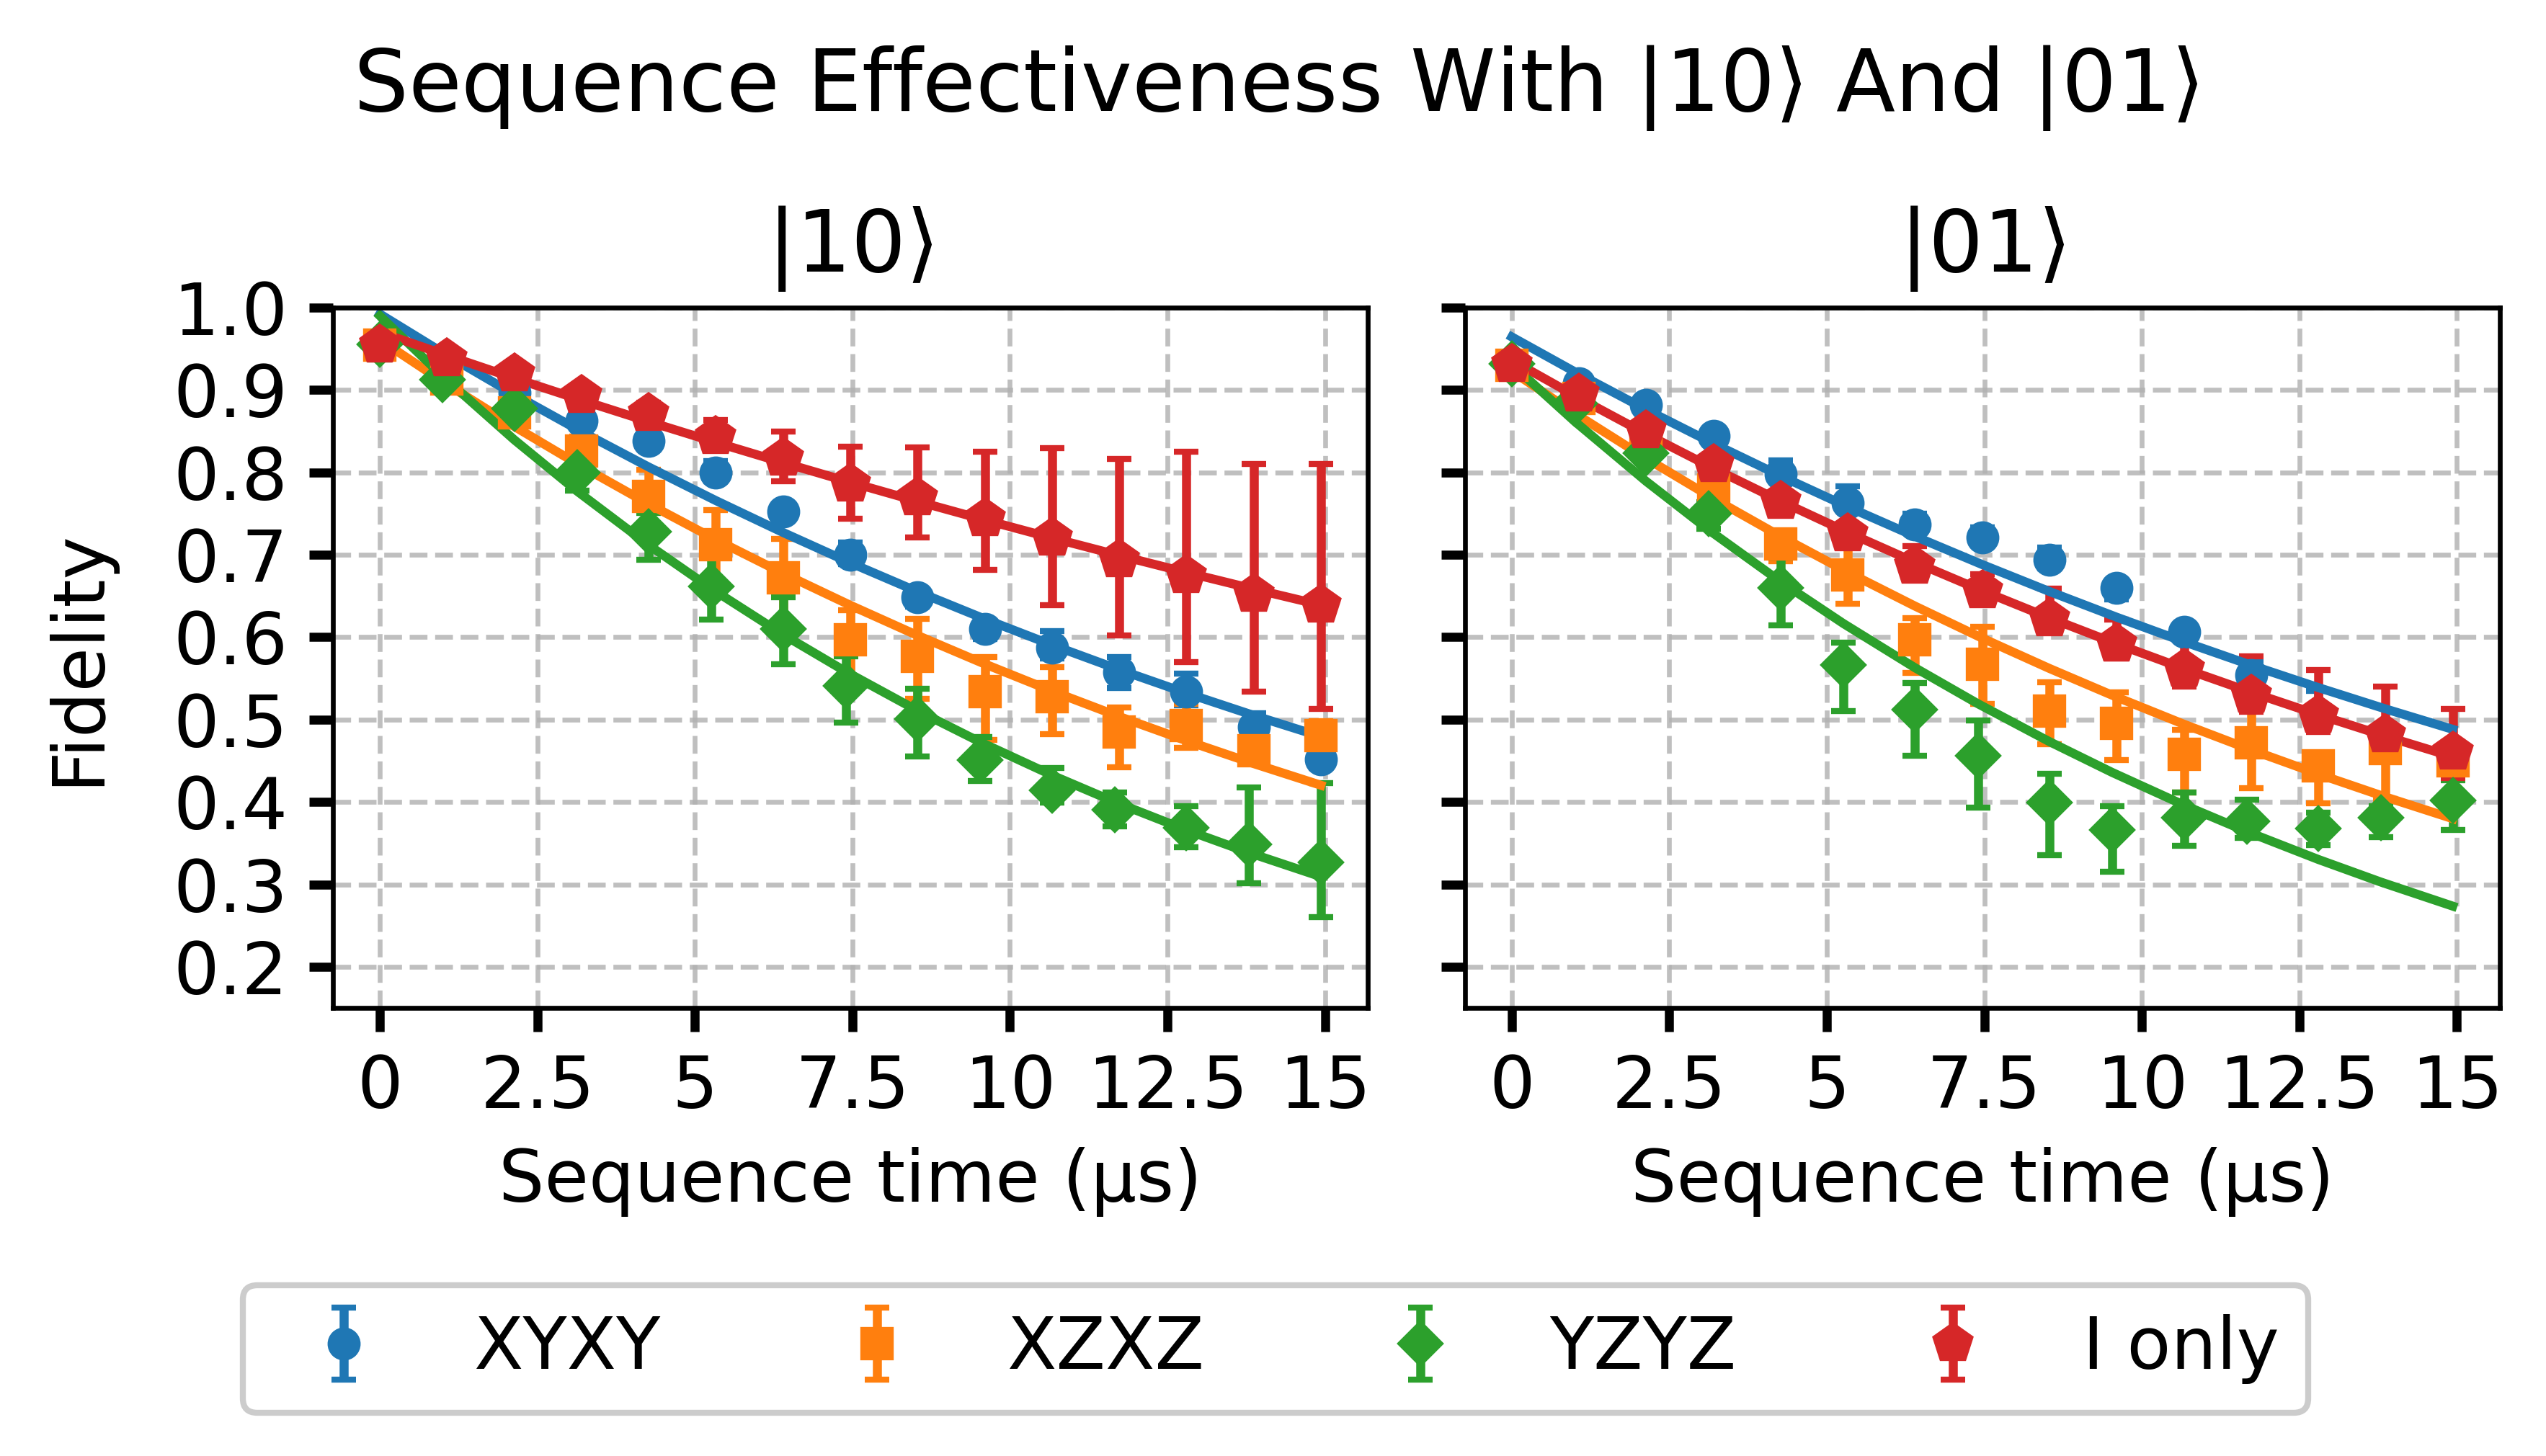

In [18]:
def exp_decay(x, T, C):
    return np.exp(-x/T) + C

labels = ["$|10\\rangle$", "$|01\\rangle$"]

fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True, sharex=True, figsize=(6,3), constrained_layout=False, dpi=600)

fig.suptitle("Sequence Effectiveness With $|10\\rangle$ And $|01\\rangle$", fontsize="x-large", y=0.955)
axs[0].set_ylabel("Fidelity", labelpad=10, fontsize="large")

msize = 4.5 # Markersize
msize_scatter = 10 # Markersize for scatter plots
medgewidth = 1 # Marker edge width
mtype = "o" # Marker type
mtype_scatter = "_" # Marker type in scatter plots
lw = 1.5 # Line width
elw = 1.5 # Error bar line width
a = 1 # Alpha (transparency)
cs = 2 # Error bar cap size

# Marker options
marker_types = ["o", "s", "D", "p"]
marker_sizes = [msize, msize, msize, 6]


# Plot the results
for i in range(2): # For each state
        
    axs[i].set_title(labels[i], fontsize="x-large")
    axs[i].set_ylim((0.15,1))
    axs[i].set_xticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
    axs[i].set_xticklabels([0, 2.5, 5, 7.5, 10, 12.5, 15], fontsize="large")
    axs[i].set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    axs[i].tick_params(width=1.5, length=4)
    
    # Get the wait times
    t_XYXY = all_wait_times[i][0]
    t_XZXZ = all_wait_times[i][1]
    t_YZYZ = all_wait_times[i][2]
    t_IIII = all_wait_times[i][3]
    
    # Get the fidelities
    fidelity_XYXY = avg_counts00[i][0]/shots
    fidelity_XZXZ = avg_counts00[i][1]/shots
    fidelity_YZYZ = avg_counts00[i][2]/shots
    fidelity_IIII = avg_counts00[i][3]/shots
    
    # For the error bar limits
    min_err_XYXY = np.abs(fidelity_XYXY-min_counts00[i][0]/shots)
    max_err_XYXY = np.abs(fidelity_XYXY-max_counts00[i][0]/shots)
    min_err_XZXZ = np.abs(fidelity_XZXZ-min_counts00[i][1]/shots)
    max_err_XZXZ = np.abs(fidelity_XZXZ-max_counts00[i][1]/shots)
    min_err_YZYZ = np.abs(fidelity_YZYZ-min_counts00[i][2]/shots)
    max_err_YZYZ = np.abs(fidelity_YZYZ-max_counts00[i][2]/shots)
    min_err_IIII = np.abs(fidelity_IIII-min_counts00[i][3]/shots)
    max_err_IIII = np.abs(fidelity_IIII-max_counts00[i][3]/shots)
    
    # Plot the data
    axs[i].errorbar(t_XYXY, fidelity_XYXY, yerr=[min_err_XYXY, max_err_XYXY],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[0], markeredgewidth=medgewidth, markersize=marker_sizes[0], 
                alpha=a, c="C0",
                label="XYXY")
    axs[i].errorbar(t_XZXZ, fidelity_XZXZ, yerr=[min_err_XZXZ, max_err_XZXZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[1], markeredgewidth=medgewidth, markersize=marker_sizes[1], 
                alpha=a, c="C1",
                label="XZXZ")
    axs[i].errorbar(t_YZYZ, fidelity_YZYZ, yerr=[min_err_YZYZ, max_err_YZYZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[2], markeredgewidth=medgewidth, markersize=marker_sizes[2], 
                alpha=a, c="C2",
                label="YZYZ")
    axs[i].errorbar(t_IIII, fidelity_IIII, yerr=[min_err_IIII, max_err_IIII],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[3], markeredgewidth=medgewidth, markersize=marker_sizes[3], 
                alpha=a, c="C3",
                label="I only")
    
    # Plot the fits
    for k in range(4):
        state_data = avg_counts00[i][k]/shots
        state_times = all_wait_times[i][k]
        exp_model = Model(exp_decay)
        exp_model.set_param_hint('T', value=20, min=0)
        exp_model.set_param_hint('C', value=-0.1)
        fit_result = exp_model.fit(state_data, x=state_times)
        
        # Print the resulting fit parameters with their standard error
        print(i, k)
        fit_result.params.pretty_print(columns=["value", "stderr"])
        print()
        
        # Plot the curve of the best fit
        ploty = fit_result.best_fit
        axs[i].plot(state_times, ploty, linewidth=lw, alpha=a, c="C"+str(k))

    axs[i].grid(linestyle="--", alpha=0.8, zorder=0.1)

axs[0].set_yticklabels([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize="large")     
axs[0].set_xlabel("Sequence time (μs)", fontsize="large")
axs[1].set_xlabel("Sequence time (μs)", fontsize="large")

# Create the legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.025), fontsize="large", framealpha=1)

# Show
fig.tight_layout()
plt.show()
#plt.savefig(r"fidelityTwoQubit34_01_10.pdf")  